# Error Simulation
Within Lightworks, it is possible to simulate a number of errors which can occur within linear optic systems, this includes loss, source & detector imperfections. This notebook demonstrates the inclusion of each of these.

In [1]:
from random import random, seed

import matplotlib.pyplot as plt
import numpy as np

import lightworks as lw
from lightworks import emulator

## Loss
In photonic systems, loss is a critical error source which results in the erasure of quantum information from systems. For interferometric systems, imbalances in loss will also limit fidelity of the operations implemented. Losses in lightworks can be added to the system through the loss method.

To see the effect of this on a small system, below we add a loss element to a single output mode of a 50:50 beam splitter. The loss elements can be viewed with the display_loss option.

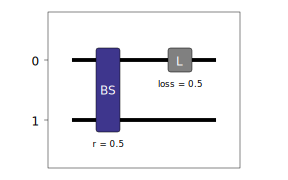

In [2]:
lossy_circuit = lw.PhotonicCircuit(2)

lossy_circuit.bs(0, reflectivity=0.5)
lossy_circuit.loss(0, 0.5)

lossy_circuit.display(display_loss=True)

When this circuit is then sampled with a single photon input, it can be seen how the probability distribution is skewed which could alter any conclusions derived from the results. Without loss, it is expected that both $\ket{1,0}$ and $\ket{0,1}$ would be seen in near equal amounts.

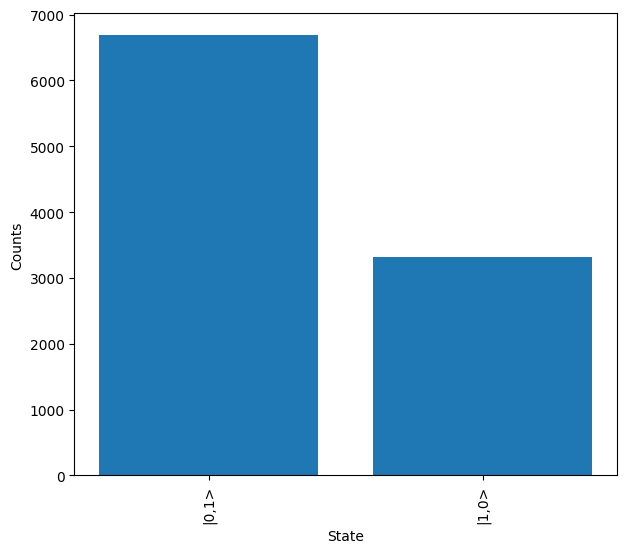

In [3]:
backend = emulator.Backend("permanent")

sampler = lw.Sampler(
    lossy_circuit, lw.State([1, 0]), 10000, min_detection=1, random_seed=1
)
results = backend.run(sampler)

results.plot()

Scaling this up to a larger system, a lossy Reck interferometer can be configured and compared to the non-lossy equivalent. To achieve this we will parameterize the loss value and extract the unitary with and without loss.

It can also be seen how some components offer the option to include loss without adding these as additional elements.

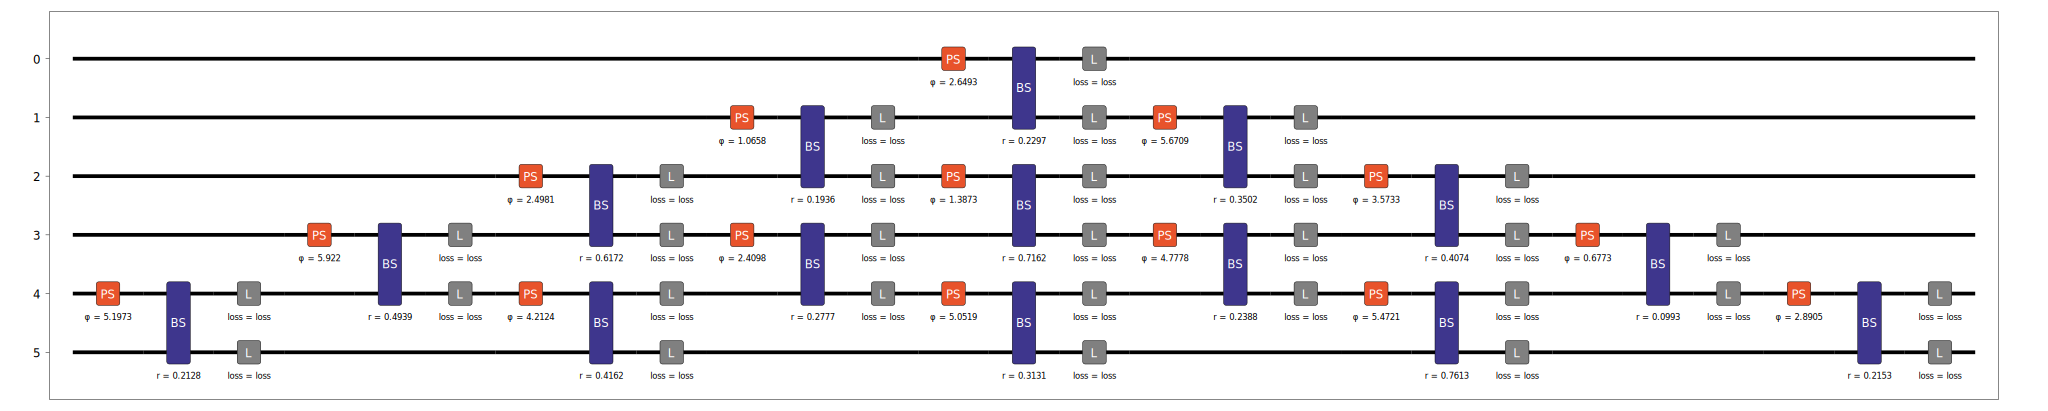

In [4]:
n_modes = 6

interferometer = lw.PhotonicCircuit(n_modes)

# Define parameter to set loss
loss = lw.Parameter(0, bounds=[0, 1], label="loss")

# Set random seed to ensure repeatability
seed(111)

for i in range(n_modes - 1):
    for j in range(0, n_modes - 1 - i, 1):
        interferometer.barrier(
            [n_modes - 2 - j, n_modes - 1 - j]
        )  # Use barrier to separate unit cells

        # Add randomly configured elements
        interferometer.ps(n_modes - 2 - j, 2 * np.pi * random())
        interferometer.bs(
            n_modes - 2 - j,
            reflectivity=random(),
            loss=loss,  # Include loss on beam splitter
        )

interferometer.display(display_loss=True)

Once the circuit is created, the unitary matrices are then extracted and plotted below. It can be seen how the implemented unitary transformation is altered in the presence of losses.

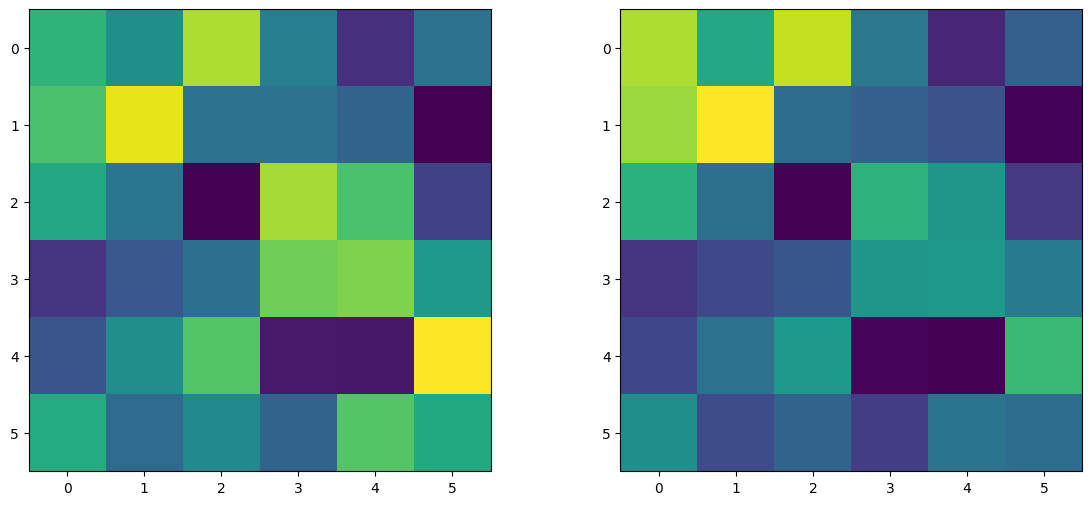

In [5]:
# Set loss to 0 and get unitary
loss.set(0)
U_ideal = interferometer.U

# Set loss to 0.2 and get unitary
loss.set(0.2)
U_lossy = interferometer.U

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].imshow(abs(U_ideal))
ax[1].imshow(abs(U_lossy))

plt.show()

## Source Imperfections

There are a number of imperfections that can be introduced within the Source. To view these, we'll configure a basic Hong-Ou-Mandel (HOM) configuration, consisting of two input photons incident on a 50:50 beam splitter. When using a perfect source the $\ket{1,1}$ input should produce an output of either $\ket{2,0}$ or $\ket{0,2}$.

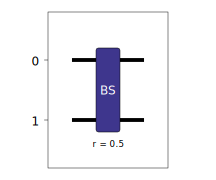

In [6]:
hom = lw.PhotonicCircuit(2)

hom.bs(0, reflectivity=0.5)

hom.display()

.. note:: Source imperfections can only be used with the Sampler.

### Indistinguishability

Indistinguishability is a measure of how similar the photons are to each other. This alters the extent to which the photons interfere, affecting the fidelity of transformations which are implemented. The model used in Lightworks assumes an identical level of indistinguishability between all photons. 

For the HOM setup, it can be seen how the presence of partial distinguishability introduces a $\ket{1,1}$ component which should not be measured.

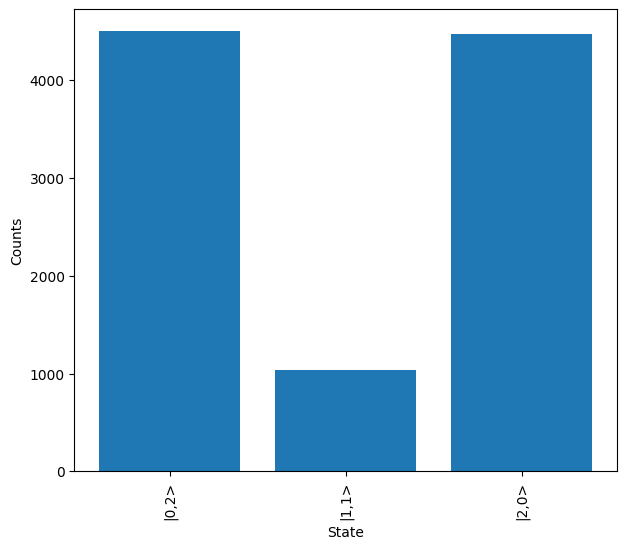

In [7]:
source = emulator.Source(indistinguishability=0.8)

sampler = lw.Sampler(
    hom, lw.State([1, 1]), 10000, source=source, random_seed=99
)
results = backend.run(sampler)

results.plot()

### Purity

Single photon purity is a measure of the multi-photon elements present in each time bin of the system. These typically result from the laser used to drive the single photon source and act as distinguishable photons to the generated photons from the source. When introducing this affect, it can be seen how a significant number of outputs with more than the two input photons are generated. 

Particularly in a lossy environment this leads to errors as a seemingly valid output may be measured (i.e. it has the correct number of photons) but some of these photons may be from the impure element of the single photon source, and these would interact differently when propagating through the system. 

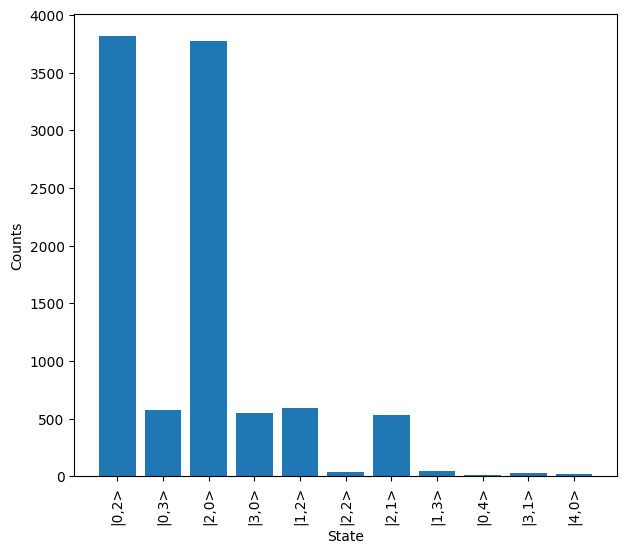

In [8]:
source = emulator.Source(purity=0.8)

sampler = lw.Sampler(
    hom, lw.State([1, 1]), 10000, source=source, random_seed=99
)
results = backend.run(sampler)

results.plot()

### Brightness

Brightness reflects the fact that a certain percentage of the time the single photon source will not emit a photon. This can lead to error but will also significantly increase the amount of samples that need to be extracted from the system.

Below, when less than ideal brightness is introduced it can be seen how a lot of the outputs no longer contain 2 output photons. Typically, this could be mitigated through the use of the option post_select = 2 in sample_N_inputs.

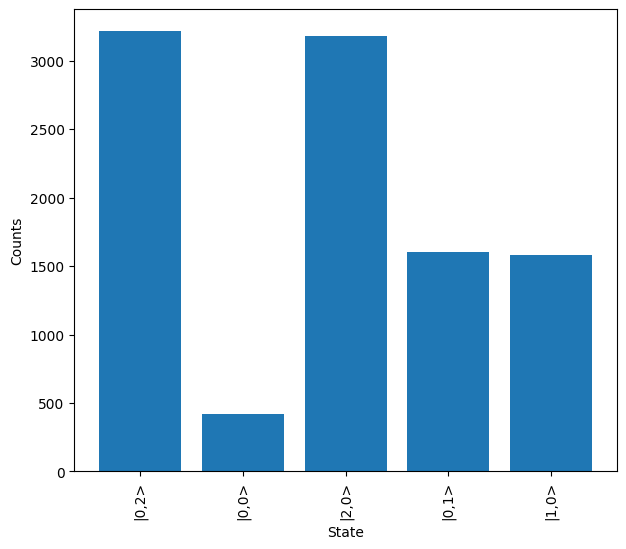

In [9]:
source = emulator.Source(brightness=0.8)

sampler = lw.Sampler(
    hom, lw.State([1, 1]), 10000, source=source, random_seed=99
)
results = backend.run(sampler)

results.plot()

.. warning::
   Each imperfection introduced through the source object requires simulation of additional inputs, so using these can have a significant impact on simulation time.

## Detector Imperfections

The exact specifications of detectors will affect the results when sampling from the system. These often need to be taken into account as it may limit or alter how certain applications are realized. The included affects are detector efficiency, dark counts and non photon number resolving detectors.

.. note::
    Detector imperfections can only be used with the Sampler, adn dark counts + sub-unity efficiency require setting the sampling mode to 'input'.

### Efficiency

A non-ideal detector efficiency means that there is a probability that each output photon is not measured. This will increase the number of samples required and potentially alters the measured results.

Using the HOM experiment from above, it can be seen how similar to source brightness the imperfect detector efficiency creates outputs with less than 2 photons measured.

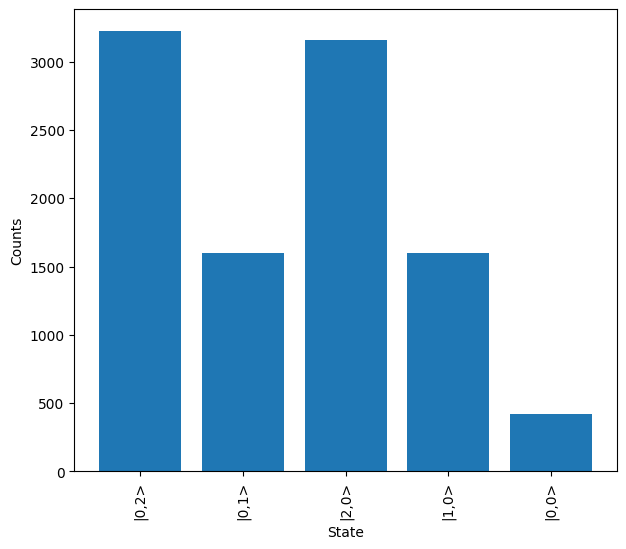

In [10]:
detector = emulator.Detector(efficiency=0.8)

sampler = lw.Sampler(
    hom,
    lw.State([1, 1]),
    10000,
    detector=detector,
    random_seed=99,
    sampling_mode="input",
)
results = backend.run(sampler)
results.plot()

### Dark counts

With all photon detection methods, dark counts occur where a detection event is registered without a photon being present. In cases where the dark count rate is large this will alter then output states measured across other modes and so it is important to understand the effect of these. 

Below, an empty input is used and the probabilistic nature of dark counts demonstrated. The dark counts rate is set with the p_dark argument and is defined as the probability of a dark count occurring within the detection time bin on a singular detector channel. 

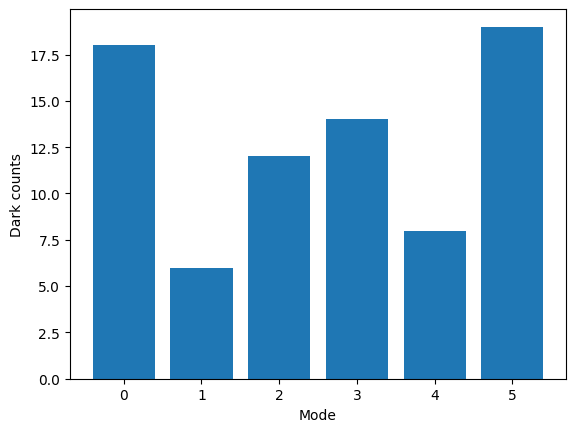

In [11]:
detector = emulator.Detector(p_dark=1e-3)

sampler = lw.Sampler(
    lw.PhotonicCircuit(6),
    lw.State([0] * 6),
    10000,
    detector=detector,
    random_seed=1,
    sampling_mode="input",
)
results = backend.run(sampler)

# Collect dark counts per mode
counts = [0] * 6
for s, c in results.items():
    for i, m in enumerate(s):
        if m >= 1:
            counts[i] += c

plt.bar(range(len(counts)), counts)
plt.xlabel("Mode")
plt.ylabel("Dark counts")
plt.show()

### Photon Number Resolving
Typically, the SNSPDs used in photonic quantum computing are not able to resolve multiple photons. This means if two or more photons exit on a mode of the QPU then only one detection event will be registered.

Again, using the HOM experiment, we set the photon_counting option to False and it can be seen how the output states are now only $\ket{1,0}$ or $\ket{0,1}$. This also means if there is loss within the system, we would not be able to distinguish between the $\ket{2,0}$ and a $\ket{1,0}$ state where 1 photon was lost from the system.

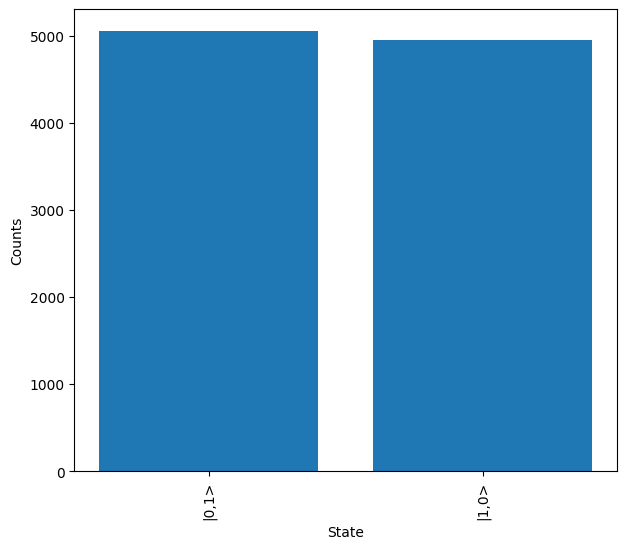

In [12]:
detector = emulator.Detector(photon_counting=False)

sampler = lw.Sampler(
    hom, lw.State([1, 1]), 10000, detector=detector, random_seed=99
)
results = backend.run(sampler)

results.plot()

## Combining All Errors
Now all of the potential error source have been introduced, we can add all of the errors into a single simulation and view the effect this has. In this case we choose to use a Hadamard and CNOT gate on a pair of dual-rail encoded to qubit to create a $\Phi^+$ bell state.

We start by simulating the ideal case and as expected the only outputs measured are $\ket{1,0,1,0}$ and $\ket{0,1,0,1}$ ($\ket{1,0}$ and $\ket{0,1}$ in qubit language respectively).

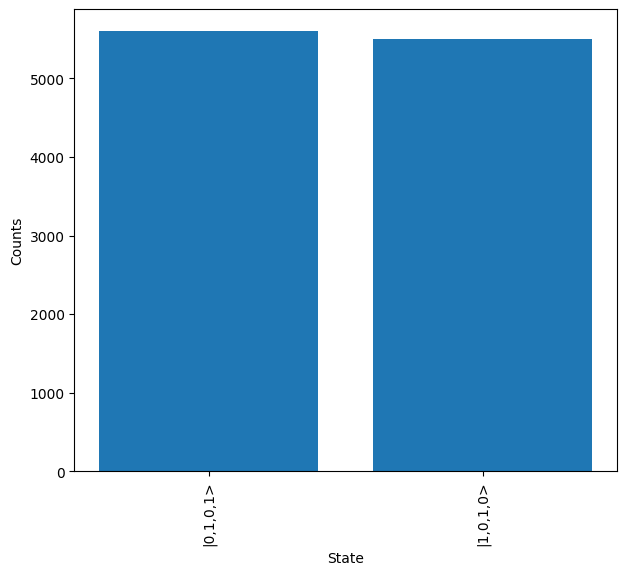

In [ ]:
loss = lw.Parameter(0)  # Define loss parameter

r = 1 / 3
theta = np.arccos(r)

bell_circuit = lw.PhotonicCircuit(6)
to_add = [
    (1, np.pi / 2, 0),
    (3, np.pi / 2, 0),
    (0, theta, 0),
    (2, theta, np.pi),
    (4, theta, 0),
    (3, np.pi / 2, 0),
]

for m, t, p in to_add:
    bell_circuit.bs(m, loss=loss, reflectivity=0.5)
    bell_circuit.ps(m + 1, t)
    bell_circuit.bs(m, loss=loss, reflectivity=0.5)
    bell_circuit.ps(m + 1, p)

# Then add required heralds
bell_circuit.herald(0, 0)
bell_circuit.herald(5, 0)

# Define required post-selection
post_select = lambda s: sum(s[0:2]) == 1 and sum(s[2:]) == 1

sampler = lw.Sampler(
    bell_circuit,
    lw.State([1, 0, 1, 0]),
    100000,
    post_selection=post_select,
    sampling_mode="input",
    random_seed=99,
)
results = backend.run(sampler)

results.plot()

The loss parameter is then updated to introduce loss, and the source and detector attribute of the Sampler are also updated. For the source, a brightness of 80%, purity of 90% & indistinguishability of 90% is chosen and for the detector, efficiency of 80%, a dark count probability of $10^{-4}$ and non photon number resolving is used. A number of error states can then be seen to be present in the system.

Interested users may wish to tweak these parameters to view the effect each has on the produced output result.

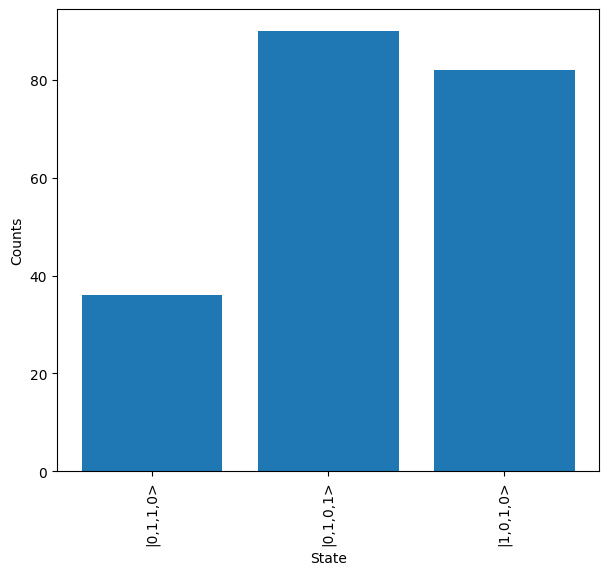

In [14]:
loss.set(0.3)
sampler.source = emulator.Source(
    brightness=0.8, indistinguishability=0.90, purity=0.90
)
sampler.detector = emulator.Detector(
    efficiency=0.8, p_dark=1e-4, photon_counting=False
)

results = backend.run(sampler)
results.plot()